In [1]:
import os
import struct
import pickle
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import PredefinedSplit
from sklearn.exceptions import ConvergenceWarning
import warnings

In [3]:
def transform_data(data, mean, scale):
    return (data - mean) / scale

def read_epp_file(file_path):
    with open(file_path, 'rb') as file:
        num_frames = struct.unpack('i', file.read(4))[0]
        frame_sec_interval = struct.unpack('i', file.read(4))[0]
        tensor_predictions = np.zeros(num_frames)
        for i in range(num_frames):
            tensor_predictions[i] = struct.unpack('ff', file.read(8))[1] # Positiveness
    return num_frames, frame_sec_interval, tensor_predictions

def read_efp_file(file_path):
    with open(file_path, 'rb') as file:
        num_frames = struct.unpack('i', file.read(4))[0]
        frame_sec_interval = struct.unpack('i', file.read(4))[0]
        tensor_predictions = np.zeros((num_frames, 3))
        for i in range(num_frames):
            tensor_predictions[i, :] = struct.unpack('fff', file.read(12)) # Filter
    return num_frames, frame_sec_interval, tensor_predictions

def extract_features(epp_data, efp_data, frameInterval):
    # Count dark frames and remove -1 values
    efp_dark_frames = np.sum(efp_data == -1, axis=0)[0]

    if len(efp_data[~np.all(efp_data == -1, axis=1)]) > 0:
        epp_data = epp_data[epp_data != -1]
        efp_data = efp_data[~np.all(efp_data == -1, axis=1)]

    # Existing features
    epp_mean = np.mean(epp_data)
    epp_std = np.std(epp_data)
    epp_min = np.min(epp_data)
    epp_max = np.max(epp_data)
    epp_median = np.median(epp_data)
    epp_combo = epp_mean - 2 * epp_std
    epp_q1, epp_q3 = np.percentile(epp_data, [25, 75])

    efp_means = np.mean(efp_data, axis=0)
    efp_stds = np.std(efp_data, axis=0)
    efp_mins = np.min(efp_data, axis=0)
    efp_maxs = np.max(efp_data, axis=0)
    efp_medians = np.median(efp_data, axis=0)
    efp_combo = efp_means[0] - 2 * efp_stds[0]
    efp_q1s, efp_q3s = np.percentile(efp_data, [25, 75], axis=0)

    # Additional features
    epp_skewness = skew(epp_data)
    epp_kurtosis = kurtosis(epp_data)
    epp_entropy = entropy(epp_data)
    epp_energy = np.sum(epp_data**2)
    try:
        if len(epp_data) != 1:
            epp_slope = np.polyfit(range(len(epp_data)), epp_data, 1)[0]
        else:
            epp_slope = 0
    except np.RankWarning:
        epp_slope = 0  # Default value in case of a fitting error

    efp_skewness = skew(efp_data, axis=0)
    efp_kurtosis = kurtosis(efp_data, axis=0)
    efp_entropy = entropy(efp_data, axis=0)
    efp_energy = np.sum(efp_data**2, axis=0)
    try:
        if len(efp_data) != 1:
            efp_slope = np.polyfit(range(len(efp_data)), efp_data, 1)[0]
        else:
            efp_slope = np.zeros(3)
    except np.RankWarning:
        efp_slope = np.zeros(3)  # Default value in case of a fitting error

    # Replace inf and -inf with large finite numbers
    epp_features = np.array([epp_mean, epp_std, epp_min, epp_max, epp_median,
                            epp_q1, epp_q3, epp_skewness, epp_kurtosis, epp_entropy])
    efp_features = np.hstack([efp_means, efp_stds, efp_mins, efp_maxs, efp_medians,
                             efp_q1s, efp_q3s, efp_skewness, efp_kurtosis, efp_entropy])
    add_features = np.array([epp_combo, efp_combo])
    
    epp_features = np.nan_to_num(epp_features, nan=0.0, posinf=1e6, neginf=-1e6)
    efp_features = np.nan_to_num(efp_features, nan=0.0, posinf=1e6, neginf=-1e6)
    add_features = np.nan_to_num(add_features, nan=0.0, posinf=1e6, neginf=-1e6)

    combined_features = np.concatenate(([efp_dark_frames], epp_features, efp_features))
    combined_features = np.append(combined_features, add_features)
    combined_features = np.append(combined_features, [epp_data.size, frameInterval])

    return combined_features, efp_means, efp_medians, efp_stds, epp_mean, epp_median, epp_std, epp_data.size

def calculate_percentiles(epp_data, efp_data):
    """
    Preprocess EPP and EFP data by removing dark frames (-1 values), then calculate values at given percentile indices.

    Parameters:
    - epp_data: numpy array of EPP data.
    - efp_data: numpy array of EFP data.

    Returns:
    - Tuple containing lists of values at the specified percentile indices for EPP and EFP data after preprocessing.
      Each list contains values at 20%, 50%, and 80% indices or NaN/full(3, NaN) if out of bounds.
    """
    # Preprocess data by removing dark frames (-1 values)
    epp_data_clean = epp_data[epp_data != -1]
    efp_data_clean = efp_data[~np.all(efp_data == -1, axis=1)]

    # Define a helper function to calculate percentiles for a single dataset
    def _calculate_for_dataset(data, is_efp=False):
        indices = (int(len(data) * 0.2), int(len(data) * 0.5), int(len(data) * 0.8))
        values = []
        for index in indices:
            if index < len(data):
                if is_efp:
                    values.append(data[index, :])
                else:
                    values.append(data[index])
            else:
                if is_efp:
                    values.append(np.full(3, np.nan))
                else:
                    values.append(np.nan)
        return values
    
    # Calculate percentiles for preprocessed EPP and EFP data
    epp_percentiles = _calculate_for_dataset(epp_data_clean, is_efp=False)
    efp_percentiles = np.hstack(_calculate_for_dataset(efp_data_clean, is_efp=True))
    
    # Convert lists to numpy arrays and concatenate them
    combined_arrays = np.concatenate((epp_percentiles, efp_percentiles))

    return combined_arrays

def load_data(folder_paths):
    X, y, filenames, frame_features = [], [], [], []
    for folder in folder_paths:
        for file_name in os.listdir(folder):
            if file_name.endswith('.epp'):
                epp_path = os.path.join(folder, file_name)
                efp_path = epp_path.replace('.epp', '.efp')
                if os.path.exists(efp_path):
                    num_frames_epp, frameInterval, epp_data = read_epp_file(epp_path)
                    num_frames_efp, _, efp_data = read_efp_file(efp_path)
                    features, efp_means, efp_medians, efp_stds, epp_mean, epp_median, epp_std, epp_count = extract_features(epp_data, efp_data, frameInterval)
                    per_feature = calculate_percentiles(epp_data, efp_data)
                    #features = np.append(features, per_feature) # Not including additional frame info
                    X.append(features)
                    y.append(folder)
                    filenames.append(file_name)
    return np.array(X), np.array(y), filenames

# Folder paths
folders = [
    '/kaggle/input/emotionlib-mpaa-rating-dataset/G',
    '/kaggle/input/emotionlib-mpaa-rating-dataset/PG',
    '/kaggle/input/emotionlib-mpaa-rating-dataset/PG-13',
    '/kaggle/input/emotionlib-mpaa-rating-dataset/R',
    '/kaggle/input/emotionlib-mpaa-rating-dataset/NC-17'
]

In [4]:
class_mapping = {
    '/kaggle/input/emotionlib-mpaa-rating-dataset/G': 0,
    '/kaggle/input/emotionlib-mpaa-rating-dataset/PG': 0.1,
    '/kaggle/input/emotionlib-mpaa-rating-dataset/PG-13': 0.3,
    '/kaggle/input/emotionlib-mpaa-rating-dataset/R': 0.7,
    '/kaggle/input/emotionlib-mpaa-rating-dataset/NC-17': 1.0
}

In [5]:
# Load dataset
X, y, filenames = load_data(folders)
y = [class_mapping[label] for label in y]

In [6]:
# Predefined test samples
filenames_test = [
 'Anime1.epp',
 'NCT-6.epp',
 'NC-17-207.epp',
 'PG-13-374.epp',
 'NC-17-237.epp',
 'NC-17-142.epp',
 'NC-17-118.epp',
 'NC-17-234.epp',
 'NC-17-186.epp',
 'GORE-3.epp',
 'NC-17-246.epp',
 'G-306.epp',
 'R-1010.epp',
 'GGT-14.epp',
 'GORE-1.epp',
 'PG-353.epp',
 'G-316.epp',
 'NC-17-154.epp',
 'NC-17-242.epp',
 'G-320.epp',
 'NCT-2.epp',
 'NC-17-146.epp',
 'G-252.epp',
 'GFOR-21.epp',
 'G-259.epp',
 'PG-13-404.epp',
 'PG-13-375.epp',
 'R-1020.epp',
 'NC-17-195.epp',
 'NC-17-129.epp',
 'NC-17-205.epp',
 'GFOR-27.epp',
 'PG-13-398.epp',
 'PG-13-364.epp',
 'R-1008.epp',
 'G-288.epp',
 'R-1032.epp',
 'PG-13-368.epp',
 'GGT-19.epp',
 'R-1005.epp',
 'NC-17-138.epp',
 'NC-17-109.epp',
 'GFOR-1.epp',
 'ncgadd-new4.epp',
 'ncpadd-new1.epp',
 'ncpadd-new2.epp',
 'ncpadd-new3.epp',
 'InGame3.epp',
 'InGame4.epp',
 'InGame5.epp']

In [7]:
# Convert data into numpy arrays for indexing
X = np.array(X)
y = np.array(y)
filenames = np.array(filenames)

# Creating indexes for the test set
test_indices = [i for i, fname in enumerate(filenames) if fname in filenames_test]

# Divide the data into test and training data
X_test = X[test_indices]
y_test = y[test_indices]
filenames_test_actual = filenames[test_indices]

# The training data is everything else
train_indices = [i for i in range(len(filenames)) if i not in test_indices]
X_train = X[train_indices]
y_train = y[train_indices]
filenames_train = filenames[train_indices]

In [8]:
# Data normalization
sc = StandardScaler()
scaler = sc.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
scaler.mean_

array([ 1.58311688e+01,  5.55404796e-01,  2.40620433e-01,  1.34919473e-01,
        9.55816977e-01,  5.49809205e-01,  3.80371281e-01,  7.35692055e-01,
       -2.19398708e-01,  2.31407394e+00,  5.11790634e+00,  6.80222175e-01,
        1.39247563e-01,  1.70140651e-01,  2.27382220e-01,  1.37751335e-01,
        1.72275958e-01,  1.58055814e-01,  1.19851955e-02,  2.70086639e-02,
        9.35261992e-01,  6.54078289e-01,  7.32048970e-01,  7.26832297e-01,
        1.20478224e-01,  1.24085733e-01,  6.02802396e-01,  6.41567227e-02,
        8.33280350e-02,  8.08835410e-01,  1.84327571e-01,  1.97060436e-01,
       -9.93948816e-01,  3.62574748e+00,  3.61322080e+00,  1.06149312e+01,
        3.00319465e+01,  5.03755484e+01,  4.92940775e+00,  3.76502975e+00,
        3.78213170e+00,  7.41639300e-02,  2.25457736e-01,  8.31792208e+02,
        2.16883117e+00])

In [10]:
scaler.scale_

array([3.18888502e+01, 2.67471344e-01, 1.02456518e-01, 2.68620273e-01,
       1.39430107e-01, 3.38618551e-01, 3.48365724e-01, 2.72344548e-01,
       1.75539936e+00, 1.96275362e+01, 2.09804634e+00, 3.40258623e-01,
       2.58014338e-01, 2.65877849e-01, 1.39705952e-01, 1.38545117e-01,
       1.34293907e-01, 3.45052103e-01, 1.23419930e-01, 1.58880181e-01,
       2.36306855e-01, 4.51643296e-01, 4.17111125e-01, 4.15369021e-01,
       3.00737719e-01, 3.05664280e-01, 4.39209347e-01, 2.33296603e-01,
       2.54326563e-01, 3.71132354e-01, 3.70462467e-01, 3.52481917e-01,
       3.24158435e+00, 3.90775568e+00, 5.96500817e+00, 4.19063351e+01,
       8.06572344e+01, 1.67608573e+02, 2.29453444e+00, 1.84186837e+00,
       1.82137829e+00, 4.00045160e-01, 4.71127244e-01, 8.19172137e+02,
       1.51359722e+00])

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import max_error
import numpy as np

model = MLPRegressor(
        hidden_layer_sizes=(23, 9, 28), # Bruteforced optimal layer's arch
        random_state=42,
        solver='lbfgs',
        activation='logistic',
        max_iter=486,
        tol=0.00001
)
    
# Training the model
model.fit(X_train_scaled, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='logistic', hidden_layer_sizes=(23, 9, 28),
             max_iter=486, random_state=42, solver='lbfgs', tol=1e-05)

In [12]:
# Save model to pickle

with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [13]:
from sklearn.metrics import mean_absolute_error, max_error

# Prediction on train data
y_pred = model.predict(X_train_scaled)

# Metrics calculation
mae = mean_absolute_error(y_train, y_pred)
max_deviation = max_error(y_train, y_pred)

# Metrics output
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Maximum Deviation: {max_deviation:.4f}")

Mean Absolute Error (MAE): 0.0636
Maximum Deviation: 0.5272


In [14]:
from sklearn.metrics import mean_absolute_error, max_error

# Prediction on test data
y_pred = model.predict(X_test_scaled)

# Metrics calculation
mae = mean_absolute_error(y_test, y_pred)
max_deviation = max_error(y_test, y_pred)

# Metrics output
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Maximum Deviation: {max_deviation:.4f}")

Mean Absolute Error (MAE): 0.1055
Maximum Deviation: 0.3380


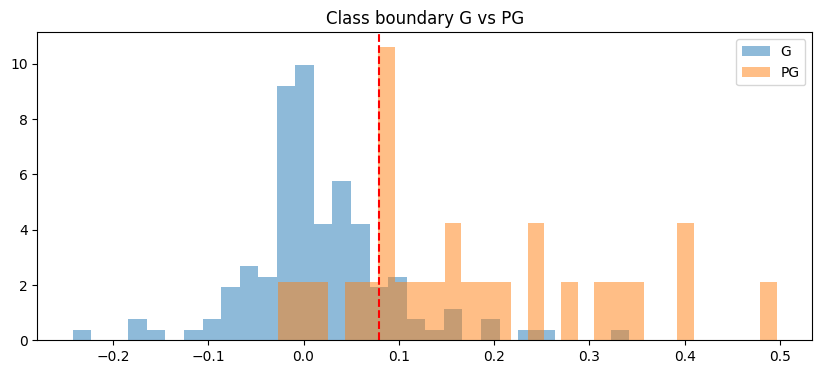

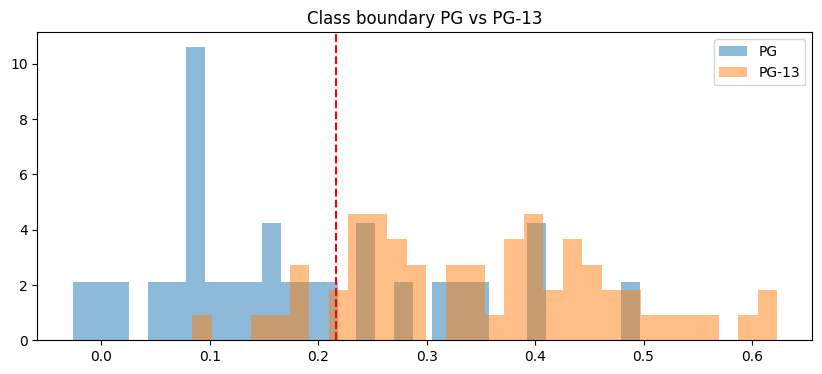

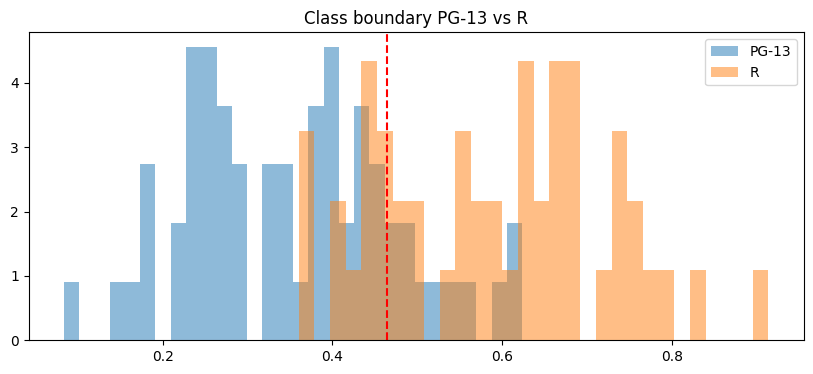

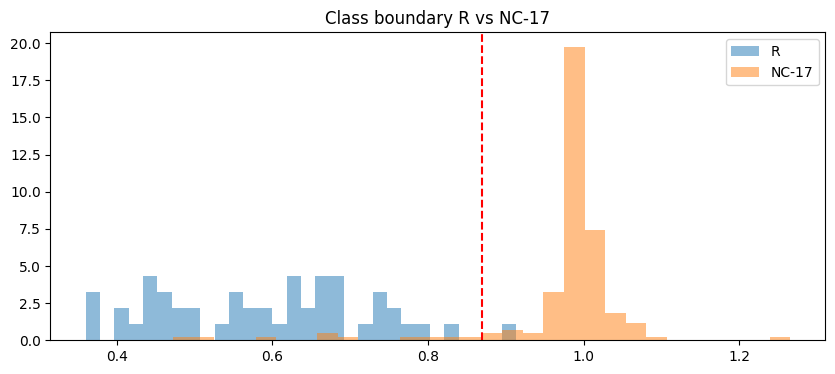

Optimal thresholds: [0.07958755591065969, 0.21603800392193215, 0.46397426048597723, 0.8694621811972619]
Accuracy: 0.8368


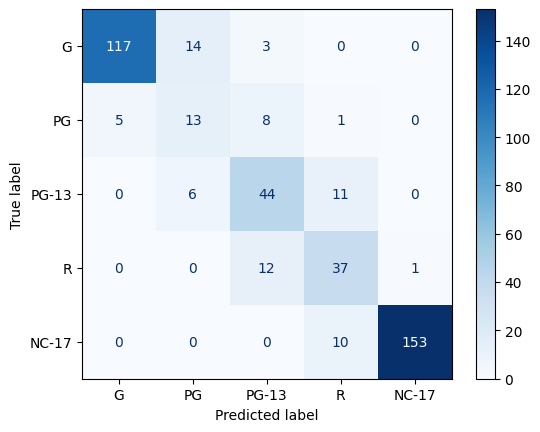

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Combining predictions and labels
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_all_pred = np.concatenate([y_train_pred, y_test_pred])
y_all_true = np.concatenate([y_train, y_test])

# Create discrete class labels
class_labels = sorted(class_mapping.values())
class_names = [k.split('/')[-1] for k in class_mapping.keys()]
int_mapping = {v: i for i, v in enumerate(class_labels)}
y_true_int = np.vectorize(int_mapping.get)(y_all_true)

# Function for finding optimal thresholds
def find_optimal_thresholds(y_pred, y_true_int, class_labels):
    thresholds = []
    n_classes = len(class_labels)
    
    for i in range(n_classes - 1):
        # Select data for the current class pair
        mask = np.isin(y_true_int, [i, i+1])
        preds = y_pred[mask]
        labels = y_true_int[mask]
        
        # Calculate density histograms
        preds0 = preds[labels == i]
        preds1 = preds[labels == i+1]
        
        if len(preds0) == 0 or len(preds1) == 0:
            thresholds.append((class_labels[i] + class_labels[i+1])/2)
            continue
            
        # Creating KDE for distributions
        kde0 = gaussian_kde(preds0)
        kde1 = gaussian_kde(preds1)
        
        # Look for the point of intersection of the distributions
        xmin = min(preds.min(), preds1.min())
        xmax = max(preds.max(), preds1.max())
        x = np.linspace(xmin, xmax, 1000)
        
        y0 = kde0(x)
        y1 = kde1(x)
        
        # Find the point of intersection
        intersection_points = np.where(np.diff(np.sign(y0 - y1)))[0]
        if len(intersection_points) > 0:
            threshold = x[intersection_points[0]]
        else:
            threshold = (class_labels[i] + class_labels[i+1])/2
        
        thresholds.append(threshold)
        
        # Visualization of distributions
        plt.figure(figsize=(10, 4))
        plt.hist(preds0, bins=30, alpha=0.5, density=True, label=class_names[i])
        plt.hist(preds1, bins=30, alpha=0.5, density=True, label=class_names[i+1])
        plt.axvline(threshold, color='red', linestyle='--')
        plt.title(f'Class boundary {class_names[i]} vs {class_names[i+1]}')
        plt.legend()
        plt.show()
        
    return thresholds

# Find optimal thresholds
thresholds = find_optimal_thresholds(y_all_pred, y_true_int, class_labels)
print("Optimal thresholds:", thresholds)

# Convert predictions into classes
edges = [-np.inf] + thresholds + [np.inf]
digitized = np.digitize(y_all_pred, bins=edges)
pred_classes = np.array([class_labels[i-1] for i in digitized])

# Estimating accuracy
accuracy = accuracy_score(y_true_int, np.vectorize(int_mapping.get)(pred_classes))
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_int, np.vectorize(int_mapping.get)(pred_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Evaluation on TEST Set ---

--- Regression Performance (Continuous Prediction vs Mapped Target) ---
Mean Squared Error (MSE): 0.0235
R2 Score: 0.8776
Mean Absolute Error (MAE): 0.1055
Maximum Deviation: 0.3380

--- Classification Performance (Applying Known Thresholds) ---
Overall Classification Accuracy: 0.7200

Classification Report (Test Set):
              precision    recall  f1-score   support

           G       1.00      0.79      0.88        14
          PG       0.00      0.00      0.00         1
       PG-13       0.38      0.43      0.40         7
           R       0.25      0.40      0.31         5
       NC-17       1.00      0.87      0.93        23

    accuracy                           0.72        50
   macro avg       0.53      0.50      0.50        50
weighted avg       0.82      0.72      0.76        50


Confusion Matrix (Test Set):


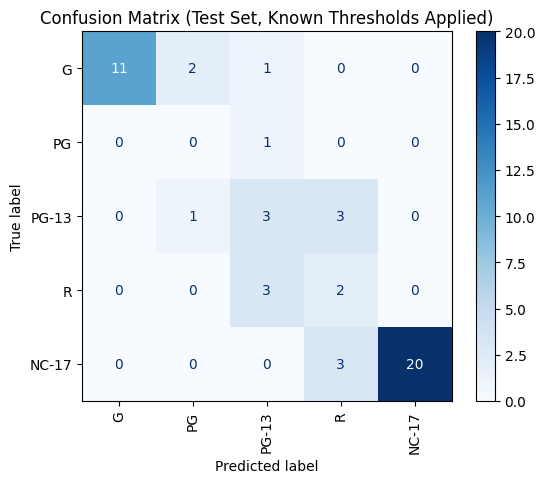


Top-8 errors by absolute difference (Continuous Prediction vs Mapped Target):
1. name: R-1010.epp, y_true_mapped: 0.70, y_pred_continuous: 0.3620, Error: 0.3380
2. name: GORE-1.epp, y_true_mapped: 1.00, y_pred_continuous: 0.6649, Error: 0.3351
3. name: R-1008.epp, y_true_mapped: 0.70, y_pred_continuous: 0.3759, Error: 0.3241
4. name: NC-17-142.epp, y_true_mapped: 1.00, y_pred_continuous: 0.6800, Error: 0.3200
5. name: PG-13-404.epp, y_true_mapped: 0.30, y_pred_continuous: 0.6184, Error: 0.3184
6. name: PG-353.epp, y_true_mapped: 0.10, y_pred_continuous: 0.3970, Error: 0.2970
7. name: Anime1.epp, y_true_mapped: 0.30, y_pred_continuous: 0.5924, Error: 0.2924
8. name: R-1020.epp, y_true_mapped: 0.70, y_pred_continuous: 0.4307, Error: 0.2693


In [17]:
# --- Final Model Evaluation on TEST Set ---

known_optimal_thresholds = thresholds
class_mapping_values = {
    0.0: 0,  # G -> 0
    0.1: 1,  # PG -> 1
    0.3: 2,  # PG-13 -> 2
    0.7: 3,  # R -> 3
    1.0: 4   # NC-17 -> 4
}
class_names = ['G', 'PG', 'PG-13', 'R', 'NC-17']

# Import necessary metrics from scikit-learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Model Evaluation on TEST Set ---")

# --- 1. Regression Metrics (Continuous Output) ---
# Get continuous predictions from the regressor model for the test set
y_pred_continuous_test = model.predict(X_test_scaled)
# y_test contains the target mapped continuous values (0.0, 0.1, 0.3, 0.7, 1.0)

print("\n--- Regression Performance (Continuous Prediction vs Mapped Target) ---")
mse_test = mean_squared_error(y_test, y_pred_continuous_test)
r2_test = r2_score(y_test, y_pred_continuous_test)
mae_test = mean_absolute_error(y_test, y_pred_continuous_test)
max_dev_test = max_error(y_test, y_pred_continuous_test)
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"R2 Score: {r2_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Maximum Deviation: {max_dev_test:.4f}")

# --- 2. Classification Metrics (Applying *Known* Thresholds) ---

print("\n--- Classification Performance (Applying Known Thresholds) ---")

if len(known_optimal_thresholds) != 4:
     print("Error: Incorrect number of thresholds defined!")
else:
    # Define the bin edges using the thresholds
    classification_edges = [-np.inf] + known_optimal_thresholds + [np.inf]

    # Convert continuous predictions to integer class indices (0-4) using thresholds
    digitized_preds_test = np.digitize(y_pred_continuous_test, bins=classification_edges)
    y_pred_int_test = digitized_preds_test - 1 # Map bin indices (1-5) to class indices (0-4)

    # Convert the true continuous mapped values (y_test) to true integer class indices (0-4)
    class_mapping_values = { 0.0: 0, 0.1: 1, 0.3: 2, 0.7: 3, 1.0: 4 }
    y_test_int = np.array([class_mapping_values.get(val, -1) for val in y_test])
    if -1 in y_test_int:
        print("Warning: Some true values in y_test did not map correctly to integer classes.")

    # Calculate Overall Accuracy
    accuracy_test = accuracy_score(y_test_int, y_pred_int_test)
    print(f"Overall Classification Accuracy: {accuracy_test:.4f}")

    # Display Classification Report (shows per-class precision, recall, f1)
    print("\nClassification Report (Test Set):")
    class_names = ['G', 'PG', 'PG-13', 'R', 'NC-17'] # Ensure this matches the integer mapping
    print(classification_report(y_test_int, y_pred_int_test, target_names=class_names, zero_division=0))

    # Display Confusion Matrix
    print("\nConfusion Matrix (Test Set):")
    cm_test = confusion_matrix(y_test_int, y_pred_int_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix (Test Set, Known Thresholds Applied)")
    plt.show()


# --- 3. Analysis of Prediction Errors ---

# Compare the continuous prediction to the target mapped continuous value
print("\nTop-8 errors by absolute difference (Continuous Prediction vs Mapped Target):")
errors_continuous_np = np.abs(y_test - y_pred_continuous_test) # y_test has 0.0, 0.1, ...

# Get indices of the largest errors in the test set
top_indices_test = np.argsort(errors_continuous_np)[-8:]

# Prepare list of tuples: (filename, true_mapped_value, predicted_continuous_value, error_magnitude)
# Use filenames_test_actual which should be defined during the split
if 'filenames_test_actual' in locals():
    filenames_test_np = np.array(filenames_test_actual)
    y_test_np = np.array(y_test) # Mapped continuous values from the test set
    y_pred_continuous_test_np = np.array(y_pred_continuous_test)

    top_pairs = []
    # Iterate through indices relative to the test set
    for index_in_test_set in reversed(top_indices_test):
         fname = filenames_test_np[index_in_test_set]
         true_val = y_test_np[index_in_test_set]
         pred_val = y_pred_continuous_test_np[index_in_test_set]
         error_val = errors_continuous_np[index_in_test_set]
         top_pairs.append((fname, true_val, pred_val, error_val))

    # Print the top errors
    for i, (fn, yt, yp, err) in enumerate(top_pairs, 1):
        print(f"{i}. name: {fn}, y_true_mapped: {yt:.2f}, y_pred_continuous: {yp:.4f}, Error: {err:.4f}")
else:
    print("Warning: `filenames_test_actual` not found. Cannot display top errors with filenames.")